**1. Import các thư viện cần thiết**

In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error as msle

**2. Đọc file dữ liệu và chia dataset theo tỉ lệ 8:2**

In [2]:
# Đọc file dữ liệu
df = pd.read_csv('D:\BID.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


**Xem** **lại** **dataset**

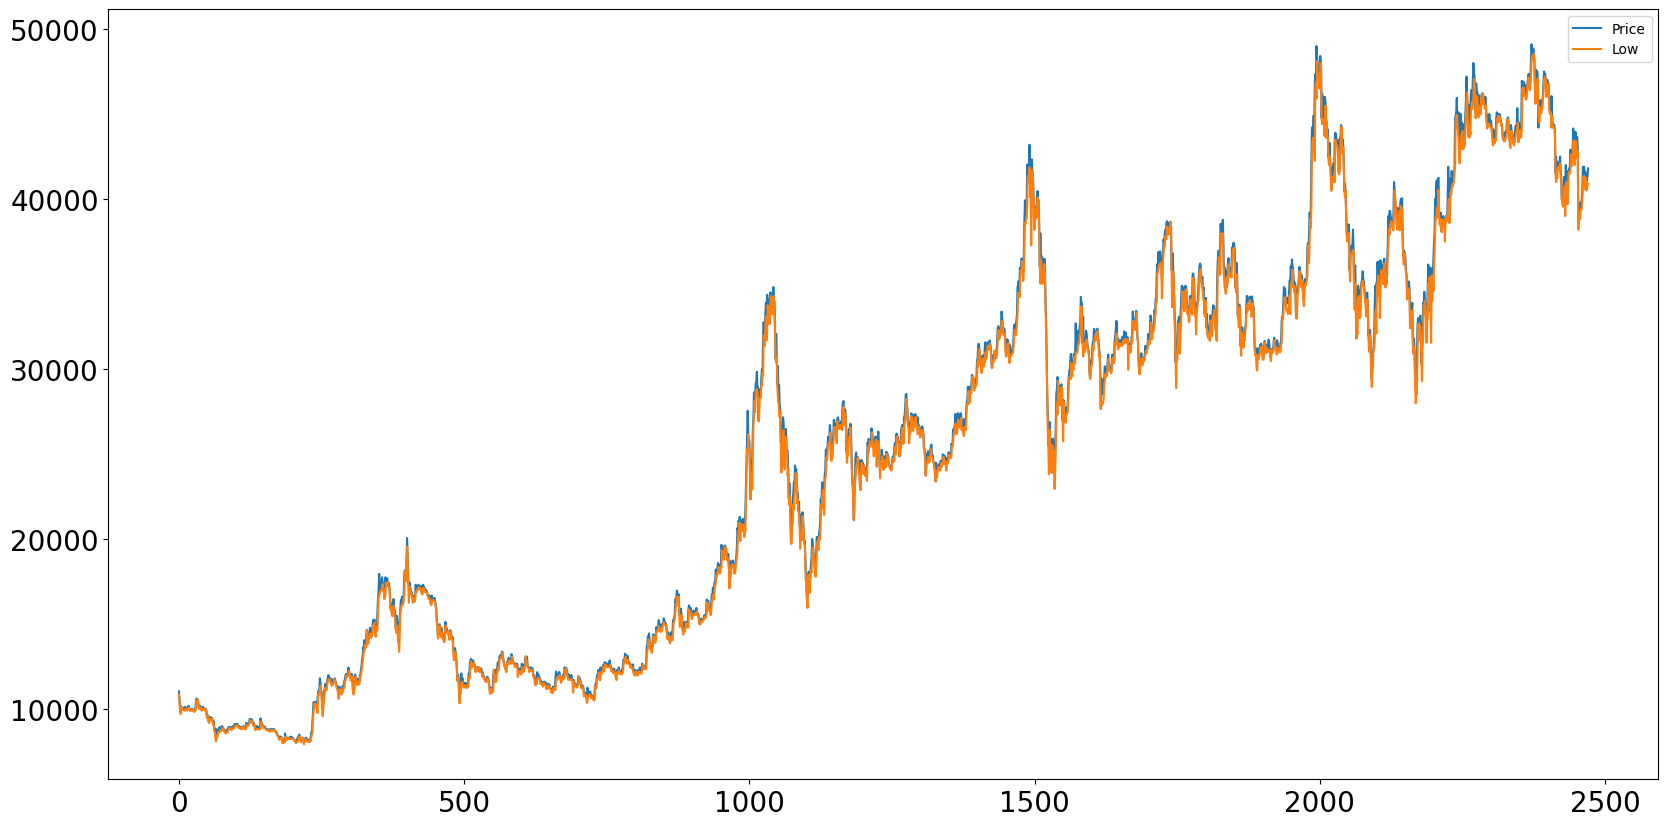

In [3]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [4]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2112075330694403,
 0.6687560278478504,
 1,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 38486.18864029625)

In [5]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [6]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-51.3605244441914,
 0.0,
 0,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 38471.01317565339)

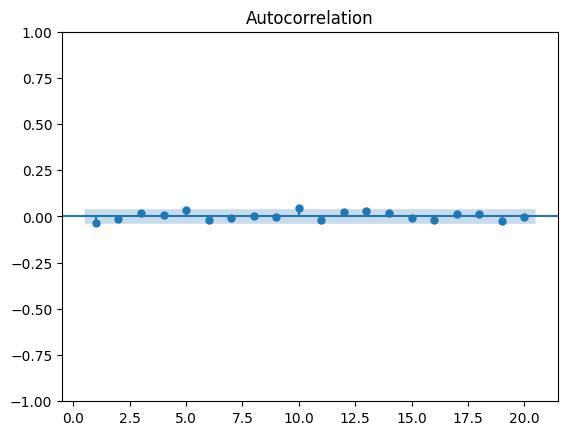

In [7]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [8]:
df

,Price,Low
0,11054.8,10874.6
1,10574.2,10574.2
2,9973.4,9913.3
3,10213.7,9733.1
4,10153.6,10153.6
...,...,...
2466,41500.0,41250.0
2467,41000.0,40500.0
2468,41200.0,40550.0
2469,41300.0,40800.0


In [9]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=30460.518, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=30462.179, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=30465.961, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=30465.973, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=30461.190, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=30469.499, Time=0.55 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=30469.492, Time=0.40 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=30461.602, Time=2.36 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=30461.629, Time=2.67 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=30467.557, Time=0.21 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=30461.569, Time=1.54 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=30461.488, Time=1.55 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=30463.537, Time=2.03 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=30466.771, Time=0.74 sec
 ARIMA(2,1,1)(1,0,1

**Dùng SARIMAX để train model**

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(2,1,2), seasonal_order=(1,0,1,5))
model_fit = model1.fit()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([35100., 35200., 35500., 37250., 36900., 36250., 37650., 38800.,
       38300., 39400., 42500., 43300., 43600., 43400., 43550., 42250.,
       46500., 46850., 45900., 48100., 47400., 47300., 47200., 46500.,
       47000., 48000., 47800., 44750., 44400., 44700., 44700., 44700.,
       43700., 44700., 45500., 43600., 44500., 43700., 43600., 42350.,
       42000., 42500., 42150., 41400., 40500., 40950., 40950., 41300.,
       41000., 41500., 41000., 43500., 43300., 43200., 43150., 43000.,
       42600., 41450., 41500., 41700., 43400., 43400., 44250., 43150.,
       42650., 43050., 41800., 40450., 40100., 40500., 39000., 37800.,
       37500., 37850., 37650., 38000., 35850., 35150., 36450., 36700.,
       36800., 36950., 37000., 37000., 34450., 33500., 35050., 33600.,
       31800., 32200., 32050., 34200., 33900., 34300., 33000., 33100.,
       34000., 35000., 34900., 35200., 35000., 34950., 34500., 34000.,
       33800., 33100., 33650., 34100., 33800., 31950., 31100., 31000.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [12]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[43459.44468179 43474.59753899 43489.75039619 43504.90325339
 43520.05611059 43535.2089678  43550.361825   43565.5146822
 43580.6675394  43595.82039661 43610.97325381 43626.12611101
 43641.27896821 43656.43182542 43671.58468262 43686.73753982
 43701.89039702 43717.04325422 43732.19611143 43747.34896863
 43762.50182583 43777.65468303 43792.80754024 43807.96039744
 43823.11325464 43838.26611184 43853.41896904 43868.57182625
 43883.72468345 43898.87754065]


***7.Đánh giá độ chính xác thuật toán***

In [13]:
#MSLE
test_msle = msle(y_test, y_pred_test)
print('Testing MSLE:', test_msle)

#RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)



Testing MSLE: 0.0004973059367941105
Testing RMSE: 861.7959779972913
Testing MAPE: 1.4076162271486952
Testing MAE: 566.1943319838057


**8. Vẽ biểu đồ**

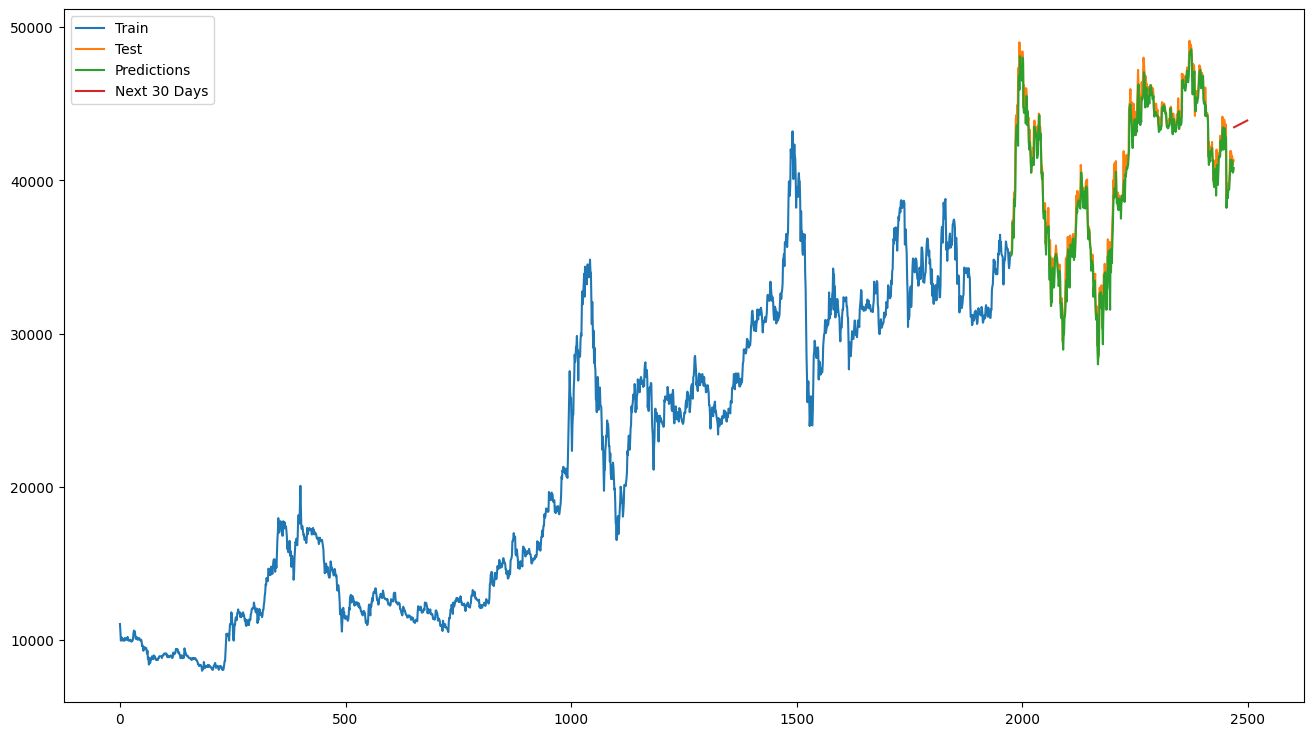

In [14]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next 30 Days'])
plt.show()